17437425_20200521_0_T2.mha
processed 17437425_20200521_0 as 17437425_20200521_0


C:\Users\simonjcs\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:365: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


2.0.0
Loading model: Y:\Stanford_Prostate\Radiology\SimonStanfordSeg\Pipeline_Paper/New_Cases/prognet_t2.h5
Y:/Stanford_Prostate/Radiology/Model_Test_05072021/Output_Wei8\resample_normalize
1/1
---- ProGNet_Prediction ----
t2_val_path: Y:/Stanford_Prostate/Radiology/Model_Test_05072021/Output_Wei8\resample_normalize
Loading MRI images: 1

t2_file_list: ['17437425_20200521_0_res_T2_hm.nii']


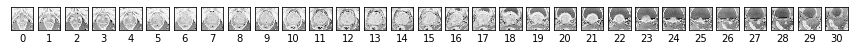

prediction (threshold 0.5)


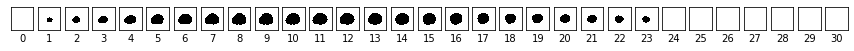

Filename: Y:/Stanford_Prostate/Radiology/Model_Test_05072021/Output_Wei8\predictions\17437425_20200521_0_prostate_label.nii
original_slice_range: [0, 30]
Finished.


In [13]:
"""
Author: Simon John Christoph Soerensen, MD (simonjcs@stanford.edu)
Created: February 16, 2021
Latest Version: June 16, 2021
Use this code to run the ProGNet prostate whole gland segmentation pipeline
Specify input and outputs in the bottom of the code
"""

from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import datetime
import numpy as np
import pandas as pd
import math
import os
import glob
import pydicom
import re
import shutil
import distutils.dir_util
import SimpleITK as sitk
import sys
from matplotlib import pyplot as plt
from itertools import chain
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import nibabel as nib
from glob import glob
from scipy.interpolate import interp1d
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import auc as skauc
from scipy import interp
from scipy.ndimage import gaussian_filter
from time import strftime
import pickle
import vtk
import pandas
import collections
from pydicom_seg import MultiClassWriter
from pydicom_seg.template import from_dcmqi_metainfo
from pyntcloud import PyntCloud
from skimage.morphology import convex_hull_object
import trimesh, struct
from random import randint

def Step2(inputFile, outputDir):
    def bbox_3D(img):

        z = np.any(img, axis=(1, 2))    #z
        c = np.any(img, axis=(0, 2))    #y
        r = np.any(img, axis=(0, 1))    #x

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
        zmin, zmax = np.where(z)[0][[0, -1]]

        #x min max, y min max, z min max
        return rmin, rmax, cmin, cmax, zmin, zmax


    def read_project_mask(accession, deidentified_name, fn_mri_T2, finalsize, finalspacing):
 

        im_mri_T2 = sitk.ReadImage(fn_mri_T2)


        T2_size = im_mri_T2.GetSize()
        T2_spacing = im_mri_T2.GetSpacing()
        T2_direction = im_mri_T2.GetDirection()
        T2_channels = im_mri_T2.GetNumberOfComponentsPerPixel() # number of channels in image

        im_T2_center = np.array(T2_size) / 2.0

         # find physical center of the histology image
        imgcenterphyspace = im_mri_T2.TransformContinuousIndexToPhysicalPoint(im_T2_center)
        #spacing is the spacing from RP cohort
        # f * T2_size[0]*T2_spacing[0] = xsize * spacing

        f1 = (finalsize *finalspacing)/(T2_size[0] *T2_spacing[0])
        f2 = (finalsize *finalspacing)/(T2_size[1]*T2_spacing[1])

        #crop around the center

        #mask_np = sitk.GetArrayFromImage(im_mask)
        #prostate = np.nonzero(mask_np)
        prostate = np.nonzero(sitk.GetArrayFromImage(im_mri_T2))
        x_coor = prostate[2]
        y_coor = prostate[1]
        z_coor = prostate[0]
        zmin = np.min(z_coor)
        zmax = np.max(z_coor)

        xmin = np.min(x_coor)
        xmax = np.max(x_coor)

        ymin = np.min(y_coor)
        ymax = np.max(y_coor)
        T2_npy = sitk.GetArrayFromImage(im_mri_T2)

        width = xmax - xmin
        height = ymax - ymin
        largerdim = np.max([width, height])
        newspacing = [finalspacing, finalspacing, T2_spacing[2]]
        percentprostate = float(largerdim/(f1 * T2_size[0]))

        if True:
            large_prostate = 0
            croppedwidth = croppedheight = int(largerdim / percentprostate)

            cropxmin = int((xmin+xmax - croppedwidth)/2)
            cropxmax = int((xmin+xmax + croppedwidth)/2)
            cropymin = int((ymin+ymax - croppedheight)/2)
            cropymax = int((ymin+ymax + croppedheight)/2)

            cropxmin = max([cropxmin, 0])
            cropxmax = min([cropxmax, T2_size[0]])
            cropymin = max([cropymin, 0])
            cropymax = min([cropymax, T2_size[0]])
            # CROP TO PROSTATE
            newnpy = T2_npy[zmin:zmax, cropymin:cropymax, cropxmin:cropxmax]
            croppedimage = sitk.GetImageFromArray(newnpy)
            # calculate new origin
            topleft = [int(cropxmin), int(cropymin), int(zmin)]
            neworigin = im_mri_T2.TransformIndexToPhysicalPoint(topleft)

            croppedimage.SetOrigin(neworigin)
            croppedimage.SetDirection(T2_direction)
            croppedimage.SetSpacing(T2_spacing)


            # RESAMPLE TO FINAL SIZE 
            finalnpy = np.zeros([croppedimage.GetSize()[2], finalsize, finalsize])
            reference = sitk.GetImageFromArray(finalnpy)
            reference.SetOrigin(neworigin)
            reference.SetDirection(T2_direction)


            newspacing = [finalspacing, finalspacing, T2_spacing[2]]
            reference.SetSpacing(newspacing)


            # MAKING RESAMPLING FILTERS
            resample = sitk.ResampleImageFilter()
            resample.SetReferenceImage(reference)
            resample.SetInterpolator(sitk.sitkLinear)

            # nearest neighbor interpolation for segmentation mask
            resampleNN = sitk.ResampleImageFilter()
            resampleNN.SetReferenceImage(reference)
            resampleNN.SetInterpolator(sitk.sitkNearestNeighbor)


            # RESAMPLE TO finalsize X finalsize x n
            resampledimage = resample.Execute(croppedimage)

            output_T2_name = target_dir_T2 + '/' + deidentified_name + '_res_T2.nii'


            sitk.WriteImage(resampledimage, output_T2_name)


            print("processed", accession, "as", deidentified_name)
        else:

            print ("prostate percent >1, did not process")
            large_prostate = 1
            """
            percentprostate2 = 0.75

            croppedwidth = croppedheight = int(largerdim / percentprostate2)
            cropxmin = int((xmin+xmax - croppedwidth)/2)
            cropxmax = int((xmin+xmax + croppedwidth)/2)
            cropymin = int((ymin+ymax - croppedheight)/2)
            cropymax = int((ymin+ymax + croppedheight)/2)

            cropxmin = max([cropxmin, 0])
            cropxmax = min([cropxmax, T2_size[0]])
            cropymin = max([cropymin, 0])
            cropymax = min([cropymax, T2_size[0]])
            """

        return large_prostate, percentprostate



    #T2_dir = sorted([o for o in os.listdir(directory) if '.mha' in o])

    target_directory =  os.path.join(outputDir, 'resample')


    if os.path.exists(target_directory) == False:
        os.makedirs(target_directory)

    target_dir_T2 = target_directory 
   

    if os.path.exists(target_dir_T2) == False:
        os.makedirs(target_dir_T2)

   
    finalsize = 256
   
    finalspacing = 0.39

   
    prostate_err_cases = []
    err_cases = []


    accession_percentprostate = {}
      

    fn_mri_T2 = inputFile
    
    T2_file = os.path.basename(inputFile)
    print(T2_file)
    
    #accession = T2_file.split('_')[0] + ('_') + T2_file.split('_')[1]
    accession = T2_file.split('_T2')[0]

    deidentified_name = accession


    errorcode = 0

    if os.path.exists(fn_mri_T2) == False:
        print ("T2 does not exist")
        errorcode = 1


    if errorcode == 0:
        prostate_err, percentprostate = read_project_mask(accession, deidentified_name, fn_mri_T2, finalsize, finalspacing)
        accession_percentprostate[accession] = percentprostate
    if prostate_err == 1:
        prostate_err_cases.append(accession)
        

def Step3(outputDir, standardHist):
    logger = logging.getLogger(__name__)


    def split_filename(filepath):
        """ split a filepath into the full path, filename, and extension (works with .nii.gz) """
        path = os.path.dirname(filepath)
        filename = os.path.basename(filepath)
        base, ext = os.path.splitext(filename)
        if ext == '.gz':
            base, ext2 = os.path.splitext(base)
            ext = ext2 + ext
        return path, base, ext


    def open_nii(filepath):
        """ open a nifti file with nibabel and return the object """
        image = os.path.abspath(os.path.expanduser(filepath))
        obj = nib.load(image)
        return obj


    def save_nii(obj, outfile, data=None, is_nii=False):
        """ save a nifti object """
        if not is_nii:
            if data is None:
                data = obj.get_data()
            nib.Nifti1Image(data, obj.affine, obj.header)\
                .to_filename(outfile)
        else:
            obj.to_filename(outfile)


    def glob_nii(dir):
        """ return a sorted list of nifti files for a given directory """
        fns = sorted(glob(os.path.join(dir, '*.nii*')))
        return fns

    def piecewise_histogram_normalize (test_flag, img_dir, output_dir, standard_hist, mask_dir=None, write_to_disk=True ):

       

        if test_flag == 0: # training images

            if os.path.exists(standard_hist) == False:
                os.mkdir(standard_hist)

      
        nyul_normalize(img_dir,  output_dir, standard_hist,mask_dir=None, write_to_disk=True)
        return


    def nyul_normalize(img_dir,  output_dir, standard_hist,mask_dir=None, write_to_disk=True):
       
        input_files = glob_nii(img_dir)
        if output_dir is None:
            out_fns = [None] * len(input_files)
        else:
            out_fns = []
            for fn in input_files:
                _, base, ext = split_filename(fn)
                out_fns.append(os.path.join(output_dir, base + '_hm' + ext))
            if not os.path.exists(output_dir):
                os.mkdir(output_dir)

        mask_files = [None] * len(input_files) if mask_dir is None else io.glob_nii(mask_dir)

        if standard_hist is None:
            logger.info('Learning standard scale for the set of images')
            standard_scale, percs = train(input_files, mask_files)
        elif not os.path.isfile(standard_hist):
            logger.info('Learning standard scale for the set of images')
            standard_scale, percs = train(input_files, mask_files)
            np.save(standard_hist, np.vstack((standard_scale, percs)))
        else:
            logger.info('Loading standard scale ({}) for the set of images'.format(standard_hist))
            standard_scale, percs = np.load(standard_hist)

        for i, (img_fn, mask_fn, out_fn) in enumerate(zip(input_files, mask_files, out_fns)):
            _, base, _ = split_filename(img_fn)
            logger.info('Transforming image {} to standard scale ({:d}/{:d})'.format(base, i+1, len(input_files)))
            img = open_nii(img_fn)
            mask = open_nii(mask_fn) if mask_fn is not None else None
            normalized = do_hist_norm(img, percs, standard_scale, mask)
            if write_to_disk:
               save_nii(normalized, out_fn, is_nii=True)

        return normalized


    def get_landmarks(img, percs):
       
        landmarks = np.percentile(img, percs)
        return landmarks


    def train(img_fns, mask_fns=None, i_min=1, i_max=99, i_s_min=1, i_s_max=100, l_percentile=10, u_percentile=90, step=10):
       
        mask_fns = [None] * len(img_fns) if mask_fns is None else mask_fns
        percs = np.concatenate(([i_min], np.arange(l_percentile, u_percentile+1, step), [i_max]))
        standard_scale = np.zeros(len(percs))
        for i, (img_fn, mask_fn) in enumerate(zip(img_fns, mask_fns)):
            img_data = open_nii(img_fn).get_data()
            mask = open_nii(mask_fn) if mask_fn is not None else None
            mask_data = img_data > img_data.mean() if mask is None else mask.get_data()
            masked = img_data[mask_data > 0]
            landmarks = get_landmarks(masked, percs)
            min_p = np.percentile(masked, i_min)
            max_p = np.percentile(masked, i_max)
            f = interp1d([min_p, max_p], [i_s_min, i_s_max])
            landmarks = np.array(f(landmarks))
            standard_scale += landmarks
        standard_scale = standard_scale / len(img_fns)
        return standard_scale, percs


    def do_hist_norm(img, landmark_percs, standard_scale, mask=None):
       
        img_data = img.get_data()
        mask_data = img_data > img_data.mean() if mask is None else mask.get_data()
        masked = img_data[mask_data > 0]
        landmarks = get_landmarks(masked, landmark_percs)
        f = interp1d(landmarks, standard_scale, fill_value='extrapolate')
        normed = f(img_data)
        return nib.Nifti1Image(normed, img.affine, img.header)


    test_flag =1 # set to 0 to normalize training set and save histogram or 1 to normalize test set with provided histogram
    img_dir = os.path.join(outputDir, 'resample')
    output_dir = os.path.join(outputDir, 'resample_normalize')
    piecewise_histogram_normalize (test_flag, img_dir, output_dir, standardHist )
    
    # Remove 'resample' folder
    #os.remove(img_dir)


def Step4(outputDir, modelPath, model_type_name, prostate_model_type):
    
    print(tf.__version__)

    devices = tf.config.experimental.list_physical_devices('GPU')
    for device in devices:
        tf.config.experimental.set_memory_growth(device, True)
    ## Use the following code to specify which GPU to use: 0 Quadro, 1 RTX
    if(len(devices) > 1):
        tf.config.experimental.set_visible_devices(devices[0], 'GPU')

    def get_image_slice_range(image):
        min_slice = 0
        max_slice = image.GetDepth() - 1
        return [min_slice, max_slice]

    use_t2 = True
    stack_input_slices = True
    add_flipped = True
    input_width = 256
    input_height = 256

    def get_slice_file_name(stack_input_slices):
        slice_file_name = '' if stack_input_slices else '_nonstacking' 
        return slice_file_name

    slice_file_name = get_slice_file_name(stack_input_slices)

    def get_model_checkpoint_name():
        return modelPath


    pred_mask_label_path = os.path.join(outputDir, 'predictions')    
    if not os.path.isdir(pred_mask_label_path):
        os.mkdir(pred_mask_label_path)
    #pred_mask_label_path = outputDir

    def unet(pretrained_weights = None,input_size = (256,256,1)):
        inputs = Input(input_size)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        model = Model(inputs = inputs, outputs = conv10)
        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

        #model.summary()

        if(pretrained_weights):
            model.load_weights(pretrained_weights)

        return model

    
    def showimage(img):
        plt.figure()
        plt.imshow(img)
        #plt.imshow(img, cmap=plt.cm.binary, interpolation='nearest')
        plt.colorbar()
        plt.grid(False)
        plt.show()

    def showimagelist(img_list):
        col=len(img_list)
        fig = plt.figure(figsize=(15,15))
        for i in range(col):
            plt.subplot(1,col,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(img_list[i], cmap=plt.cm.binary)
            plt.xlabel(str(i))
        plt.show()

    def load_t2_file(t2_list, t2_file, t2_path, skip_empty_slices, add_flipped):
        t2_np = 0

        active_slice_range = None

        if use_t2:
            t2 = sitk.ReadImage(os.path.join(t2_path, t2_file))
            t2_np = sitk.GetArrayFromImage(t2)
            t2_slice_range = get_image_slice_range(t2)
            active_slice_range = t2_slice_range

        for index in range(active_slice_range[0], active_slice_range[1] + 1):
            def stack_slices(slices_np, index):
                actual_slice = slices_np[index,:,:,np.newaxis]
                before_slice = []
                after_slice = []
                if index == 0:
                    before_slice = actual_slice
                else:
                    before_slice = slices_np[index-1,:,:,np.newaxis]

                if index == len(slices_np) - 1:
                    after_slice = actual_slice
                else:
                    after_slice = slices_np[index+1,:,:,np.newaxis]

                stacked_slices = np.concatenate((before_slice, actual_slice, after_slice),-1)
                return stacked_slices

            # Add t2
            if stack_input_slices:
                stacked_slices = stack_slices(t2_np, index)

                t2_list.append(stacked_slices)

                if add_flipped:
                    # flip around y-axis (left <-> right)
                    t2_list.append(stacked_slices[:,::-1,:])
            else:
                slice = t2_np[index,:,:,np.newaxis]

                t2_list.append(slice)

                if add_flipped:
                    # flip around y-axis (left <-> right)
                    t2_list.append(slice[:,::-1,:])

    def load_t2(t2_dir, t2_path, skip_empty_slices, add_flipped, file_filter=None):
        t2_list = []
        t2_file_list = []
        counter = 1     

        for t2_file in t2_dir:

            if file_filter != None and t2_file.find(file_filter) < 0:
                continue

            t2_file_list.append(t2_file)

            load_t2_file(t2_list, t2_file, t2_path, skip_empty_slices, add_flipped)

            if file_filter == None:
                print('\rLoading MRI images: %d / %d' % (counter, len(t2_dir)), end='\r')
            else:
                print('\rLoading MRI images: %d' % (counter), end='\r')

            counter = counter + 1

        print("\n")

        if len(t2_file_list) == 0:
            print("Could not find any t2 using file filter: '%s'" % (file_filter))
            return None, None, [], []

        t2_list = np.asarray(t2_list)

        return t2_list, t2_file_list

    def dice_coef(y_true, y_pred, smooth=1):
        # Assume pixles outside the prostate are -1 in y_pred, remove these before calculating y_true
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.where(tf.equal(y_true, 2), tf.zeros_like(y_pred), y_pred)
        y_true = tf.where(tf.equal(y_true, 2), tf.zeros_like(y_true), y_true)

        intersection = K.sum(tf.multiply(y_true, y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        #union = K.sum(y_true) + K.sum(y_pred)
        return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

    def make_model():
        model = unet(input_size=(input_width,input_height, 3 if stack_input_slices else 1))

        opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[dice_coef])

        #model.summary()
        return model

    def make_and_load_model():
        model = make_model()
        model_checkpoint_name = get_model_checkpoint_name()
        load_model(model, model_checkpoint_name)
        return model    

    def load_model(model, model_checkpoint_name):   
        print("Loading model: " + model_checkpoint_name)
        try:
            model.load_weights(model_checkpoint_name)
        except:
            print("Could not load model: " + model_checkpoint_name)

    def save_prediction(image_data, filename, original_image, active_slice_range=None):
        original_slice_range = get_image_slice_range(original_image)
        if active_slice_range != None:
            original_slice_range = active_slice_range
        print("original_slice_range: " + str(original_slice_range))

        image_data_all_slices = np.zeros((original_image.GetDepth(), original_image.GetWidth(), original_image.GetHeight()), dtype=image_data.dtype)
        image_data_all_slices[original_slice_range[0]:original_slice_range[1]+1,:,:] = np.squeeze(image_data[:,:,:])

        image_data = image_data_all_slices

        pred_vol = 255 * image_data
        pred_vol = np.squeeze(pred_vol)
        pred_vol = sitk.GetImageFromArray(pred_vol)
        pred_vol.SetSpacing(original_image.GetSpacing())
        pred_vol.SetDirection(original_image.GetDirection())
        pred_vol.SetOrigin(original_image.GetOrigin())
        origin_x = original_image.GetOrigin()[0] + (((original_image.GetSize()[0] - pred_vol.GetSize()[0]) * 0.5))*original_image.GetSpacing()[0]
        origin_y = original_image.GetOrigin()[1] + (((original_image.GetSize()[1] - pred_vol.GetSize()[1]) * 0.5))*original_image.GetSpacing()[1]
        pred_vol.SetOrigin([origin_x, origin_y, original_image.GetOrigin()[2]])
        sitk.WriteImage(pred_vol, filename)
        return pred_vol

    def evaluate_patient_partial(patient_number, name, model, t2_path, use_prediction=True):
        t2_dir = [file for file in sorted(os.listdir(t2_path))]
        return evaluate_patient_full(patient_number, name, model, t2_dir, t2_path, use_prediction)

    def get_used_width_height(image_np, threshold):
        max_width = 0
        max_height = 0
        count_y = 0
        for y in range(len(image_np)):
            count_x = 0
            for x in range(len(image_np[y])):
                if(image_np[y, x] >= 0.5):
                    count_x = count_x + 1
            if count_x > max_width:
                max_width = count_x
            if count_x > 0:
                count_y = count_y + 1
        if count_y > max_height:
            max_height = count_y
        return max_width, max_height

    def remove_bottom_small_slides(image_np, prediction_threshold, width_threashold, height_threashold):
        image_np = np.copy(image_np)

        for i in range(len(image_np)):
            max_width, max_height = get_used_width_height(image_np[i,:,:,0], prediction_threshold)

            if max_width <= width_threashold and max_height <= height_threashold:
                image_np[i,:,:,0] = 0
            else:
                break

        return image_np

    def remove_trailing_slides(image_np):
        image_np = np.copy(image_np)
        last_slice_empty = False
        found_non_empty_slice = 0
        for i in range(len(image_np)):
            nonzeroes = np.nonzero(image_np[i])
            if(len(nonzeroes) == 0 or len(nonzeroes[0]) == 0):
                last_slice_empty = True
            else:
                if found_non_empty_slice >= 5 and last_slice_empty:
                    image_np[i,:,:,0] = 0
                else:
                    found_non_empty_slice = found_non_empty_slice + 1
                    last_slice_empty = False

        return image_np

    def remove_front_slides(image_np):
        image_np = np.copy(image_np)
        last_slice_empty = False
        found_non_empty_slice = 0
        for i in reversed(range(len(image_np))):
            nonzeroes = np.nonzero(image_np[i])
            if(len(nonzeroes) == 0 or len(nonzeroes[0]) == 0):
                last_slice_empty = True
            else:
                if found_non_empty_slice >= 5 and last_slice_empty:
                    image_np[i,:,:,0] = 0
                else:
                    found_non_empty_slice = found_non_empty_slice + 1
                    last_slice_empty = False

        return image_np


    def remove_suddenly_increased_slides(image_np, prediction_threshold, margin_width, margin_height, top_to_bottom):
        image_np = np.copy(image_np)

        max_width = 0
        max_height = 0
        last_width = 0
        last_height = 0
        decrease_started = False
        remove_rest = False
        slide_range = reversed(range(len(image_np))) if top_to_bottom else range(len(image_np))
        for i in slide_range:
            if remove_rest:
                image_np[i,:,:,0] = 0
                continue

            width, height = get_used_width_height(image_np[i,:,:,0], prediction_threshold)
            #print("%d, width: %d, height: %d" % (i, width, height))

            if decrease_started and ((width > last_width + margin_width) or (height > last_height + margin_height)):
                remove_rest = True
                image_np[i,:,:,0] = 0
                continue

            if width > max_width:
                max_width = width

            if height > max_height:
                max_height = height

            if (width <= max_width - margin_width) and (height <= max_height - margin_height):
                decrease_started = True

            last_width = width
            last_height = height

        return image_np


    def paint_island_map(image_np_orig, threshold, island_map_np, index, x_orig, y_orig):
        height = len(image_np_orig)
        width = len(image_np_orig[0])

        points_to_check = [[x_orig, y_orig]]

        while len(points_to_check) > 0:
            x, y = points_to_check.pop(0)

            if image_np_orig[y, x] >= threshold and island_map_np[y, x] == 0:
                island_map_np[y, x] = index
            else:
                continue

            if x + 1 < width:
                points_to_check.append([x+1,y])
            if x - 1 >= 0:
                points_to_check.append([x-1,y])

            if y + 1 < height:
                points_to_check.append([x,y+1])
            if y - 1 >= 0:
                points_to_check.append([x,y-1])

            if y + 1 < height:
                if x + 1 < width:
                    points_to_check.append([x+1,y+1])
                if x - 1 >= 0:
                    points_to_check.append([x-1,y+1])

            if y - 1 >= 0:
                if x + 1 < width:
                    points_to_check.append([x+1,y-1])
                if x - 1 >= 0:
                    points_to_check.append([x-1,y-1])


    def get_island_map(image_np_orig, threshold):
        height = len(image_np_orig)
        width = len(image_np_orig[0])
        island_map_np = np.zeros((height, width), dtype=float)
        island_index = 1
        island_sizes = {}

        for y in range(len(island_map_np)):
            for x in range(len(island_map_np[y])):
                if image_np_orig[y, x] >= threshold and island_map_np[y, x] == 0:
                    index = island_index
                    island_sizes[island_index] = 0
                    island_index = island_index + 1
                    paint_island_map(image_np_orig, threshold, island_map_np, index, x, y)

        for y in range(len(island_map_np)):
            for x in range(len(island_map_np[y])):
                if image_np_orig[y, x] >= threshold:
                    index = island_map_np[y, x]
                    assert(index != 0)
                    island_sizes[index] = island_sizes[index] + 1

        return island_map_np, island_sizes

    def compare_island_maps(island_map_np, last_island_map_np):
        island_count = {}
        for y in range(len(island_map_np)):
            for x in range(len(island_map_np[y])):
                index = island_map_np[y, x]
                if index != 0 and last_island_map_np[y, x] != 0:
                    if index in island_count:
                        island_count[index] = island_count[index] + 1
                    else:
                        island_count[index] = 1

        winner_index = -1
        winner_count = 0
        for index in island_count:
            if island_count[index] > winner_count:
                winner_index = index
                winner_count = island_count[index]

        return winner_index

    def remove_all_other_islands(image_np, island_map_np, index):
        for y in range(len(island_map_np)):
            for x in range(len(island_map_np[y])):
                if island_map_np[y, x] != index:
                    island_map_np[y, x] = 0
                    image_np[y, x] = 0

    def remove_islands_from_slides(image_np, prediction_threshold):
        image_np = np.copy(image_np)

        last_island_map_np = None
        for i in range(len(image_np)):
            island_map_np, island_sizes = get_island_map(image_np[i,:,:,0], prediction_threshold)
            if len(island_sizes) > 1:

                if i > 0:
                    winner_index = compare_island_maps(island_map_np, last_island_map_np)
                    remove_all_other_islands(image_np[i], island_map_np, winner_index)

            last_island_map_np = island_map_np

        return image_np

    def get_slice_pixel_count(image_np, threshold):
        count = 0
        for y in range(len(image_np)):
            for x in range(len(image_np[y])):
                if image_np[y, x] >= threshold:
                    count = count + 1
        return count

    def remove_small_slice_groups(image_np, threshold, max_group_drop_percentage):
        image_np = np.copy(image_np)

        group_list = []
        group_current = []
        group_pixel_count = 0
        group_pixel_count_max_slice = 0
        group_drop_percentage = 0

        for i in range(len(image_np)):
            pixel_count = get_slice_pixel_count(image_np[i,:,:,0], threshold)
            pixel_count_next = 0
            if i + 1 < len(image_np):
                pixel_count_next = get_slice_pixel_count(image_np[i+1,:,:,0], threshold)
            if pixel_count > 0:
                if group_pixel_count_max_slice > 0:
                    group_drop_percentage_current = (group_pixel_count_max_slice - pixel_count) / group_pixel_count_max_slice
                    if group_drop_percentage_current > group_drop_percentage:
                        group_drop_percentage = group_drop_percentage_current
                if pixel_count > group_pixel_count_max_slice:
                    group_pixel_count_max_slice = pixel_count
                elif pixel_count < pixel_count_next and group_drop_percentage >= max_group_drop_percentage:
                    if len(group_current) > 0:
                        group_list.append([group_pixel_count, group_current])
                        group_current = []
                        group_pixel_count = 0
                        group_pixel_count_max_slice = 0
                        group_drop_percentage = 0
                    continue

                group_current.append(i)
                group_pixel_count = group_pixel_count + pixel_count
            elif len(group_current) > 0:
                group_list.append([group_pixel_count, group_current])
                group_current = []
                group_pixel_count = 0
                group_pixel_count_max_slice = 0
                group_drop_percentage = 0

        if len(group_current) > 0:
            group_list.append([group_pixel_count, group_current])
            group_current = []
            group_pixel_count = 0

        max_group_indexes = []
        max_group_pixel_count = 0

        if len(group_list) > 1:
            for i in range(len(group_list)):
                pixel_count, indexes = group_list[i]
                if len(indexes) > len(max_group_indexes):
                    max_group_pixel_count = pixel_count
                    max_group_indexes = indexes

            for i in range(len(image_np)):
                if not i in max_group_indexes:
                    image_np[i,:,:,0] = 0

        return image_np

    
    def remove_small_slices(image_np, threshold, min_pixel_percentage):
        image_np = np.copy(image_np)

        min_pixel_count = len(image_np[0]) * len(image_np[0][0]) * min_pixel_percentage
        #print(min_pixel_count)

        for i in range(len(image_np)):
            pixel_count = get_slice_pixel_count(image_np[i,:,:,0], threshold)
            #print([i, pixel_count])
            if pixel_count <= min_pixel_count:
                image_np[i,:,:,0] = 0

        return image_np
    
    def remove_small_slides_bottom_and_top(image_np, prediction_threshold, width_threashold, height_threashold):
        image_np = np.copy(image_np)

        for i in range(len(image_np)):
            max_width, max_height = get_used_width_height(image_np[i,:,:,0], prediction_threshold)

            if max_width <= width_threashold or max_height <= height_threashold:
                image_np[i,:,:,0] = 0
            else:
                break

        for i in reversed(range(len(image_np))):
            max_width, max_height = get_used_width_height(image_np[i,:,:,0], prediction_threshold)

            if max_width <= width_threashold or max_height <= height_threashold:
                image_np[i,:,:,0] = 0
            else:
                break

        return image_np


    def evaluate_patient_full(patient_number, val_name, model, t2_val_dir, t2_val_path, use_prediction=True):
        print("---- %s ----" % (val_name))
        print("t2_val_path: " + t2_val_path)

        t2_val_list, t2_file_list = load_t2(t2_val_dir, t2_val_path, False, False, patient_number)
        print('t2_file_list: ' + str(t2_file_list))

        if(len(t2_val_list) == 0):
            return

        if(len(t2_file_list) > 1 and patient_number != None):
            print("Error: Found multiple patients matching the patient number. Use 'None' for all patients.")
            return

        prediction = model.predict(t2_val_list, verbose=0)
        
        if prostate_model_type:
            #WG        
            prediction_threshold = 0.5

            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0
            
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 29, 29)        
            prediction = gaussian_filter(prediction, sigma=1)
            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 29, 29)
            prediction = remove_small_slices(prediction, prediction_threshold, 0.035)
            prediction = remove_islands_from_slides(prediction, prediction_threshold)
            prediction = remove_small_slice_groups(prediction, prediction_threshold, 0.40)
            prediction = remove_trailing_slides(prediction)
            prediction = remove_front_slides(prediction)
            prediction = remove_suddenly_increased_slides(prediction, prediction_threshold, 5, 5, False)
            prediction = remove_suddenly_increased_slides(prediction, prediction_threshold, 5, 5, True)
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 29, 29)

            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0
        
        else:
            #CG
            prediction_threshold = 0.5
            
            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0
            
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 20, 20)        
            prediction = gaussian_filter(prediction, sigma=1)
            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 20, 20)
            prediction = remove_small_slices(prediction, prediction_threshold, 0.008)
            prediction = remove_islands_from_slides(prediction, prediction_threshold)
            prediction = remove_small_slice_groups(prediction, prediction_threshold, 0.40)
            prediction = remove_trailing_slides(prediction)
            prediction = remove_front_slides(prediction)
            prediction = remove_suddenly_increased_slides(prediction, prediction_threshold, 7, 7, False)
            prediction = remove_suddenly_increased_slides(prediction, prediction_threshold, 4, 4, True)
            prediction = remove_small_slides_bottom_and_top(prediction, prediction_threshold, 20, 20)  

            prediction[prediction >= prediction_threshold] = 1
            prediction[prediction < prediction_threshold] = 0      

            #CG end

        if(patient_number != None):
            showimagelist(t2_val_list[:,:,:,1 if stack_input_slices else 0])
            print("prediction (threshold %0.1f)" % (prediction_threshold))
            showimagelist(prediction[:,:,:,0])

            #prediction_folder = os.path.join(pred_mask_label_path, patient_number)
            prediction_folder = pred_mask_label_path
            if os.path.exists(prediction_folder) == False:
                os.makedirs(prediction_folder)

            prediction_file_name = os.path.join(prediction_folder, patient_number + '_' + model_type_name + "_label.nii");
            print("Filename: " + prediction_file_name)

            t2_val_image = sitk.ReadImage(os.path.join(t2_val_path, t2_file_list[0]))

            active_slice_range = None

            prediction_image = save_prediction(prediction, prediction_file_name, t2_val_image, active_slice_range)


    model = make_and_load_model()

    t2_val_path = os.path.join(outputDir, 'resample_normalize')

    mask_patients = [file.split('_res_T2_hm')[0] for file in sorted(os.listdir(t2_val_path))]

    def evaluate_patient_excel(name, model, t2_path, use_prediction=True):
        count=1
        for patient in mask_patients:
            print(str(count) + '/' + str(len(mask_patients)))
            count=count+1
            evaluate_patient_partial(patient, name, model, t2_path, use_prediction)

    print(t2_val_path)
    evaluate_patient_excel("ProGNet_Prediction", model, t2_val_path)


     
        
inputFile = "Y:/Stanford_Prostate/Radiology/Model_Test_05072021/Output/AllFusionImages/17437425_20200521_0_T2.mha"
outputDir = "Y:/Stanford_Prostate/Radiology/Model_Test_05072021/Output_Wei8"
standardHist = 'Y:/Stanford_Prostate/Radiology/SimonStanfordSeg/wg/std_hist_T2.npy'
modelPath = 'Y:\Stanford_Prostate\Radiology\SimonStanfordSeg\Pipeline_Paper/New_Cases/prognet_t2.h5' # WG

Step2(inputFile, outputDir)
Step3(outputDir, standardHist)
Step4(outputDir, modelPath, 'prostate', True)

distutils.dir_util.copy_tree(os.path.join(outputDir, "resample_normalize"), outputDir)
distutils.dir_util.copy_tree(os.path.join(outputDir, "predictions"), outputDir)
shutil.rmtree(os.path.join(outputDir, "resample"), True)
shutil.rmtree(os.path.join(outputDir, "resample_normalize"), True)
shutil.rmtree(os.path.join(outputDir, "predictions"), True)


print('Finished.')